Mail - antonyphilly@gmail.com

####Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [21]:
import pathlib
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import random
import PIL
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### Loading the data from the google drive

In [22]:
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive"


In [24]:
!unzip -q /content/drive/My Drive/CNN_assignment.zip
!unzip -u "/content/drive/My Drive/CNN_assignment.zip" -d "/content/drive/My Drive/Data"

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [25]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
##https://drive.google.com/file/d/1l2tgLGfba-k7qWQLPo9pAwrP1YpH14Km/view?usp=drive_link
data_dir_train = pathlib.Path("/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path("/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Test")


In [26]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [27]:
# Creating A Dataframe for path and Class mapping
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]


dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

display(original_df.sample(5))
del dataframe_dict_original

,Path,Label
708,/content/drive/My Drive/Data/CNN_assignment/Sk...,melanoma
347,/content/drive/My Drive/Data/CNN_assignment/Sk...,basal cell carcinoma
346,/content/drive/My Drive/Data/CNN_assignment/Sk...,basal cell carcinoma
181,/content/drive/My Drive/Data/CNN_assignment/Sk...,basal cell carcinoma
272,/content/drive/My Drive/Data/CNN_assignment/Sk...,basal cell carcinoma


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [28]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [30]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [31]:
# Classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes : {class_names} , {num_classes} number of classes.\n")

Classes : ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] , 9 number of classes.



### Visualizing one instance of all the nine classes present in the dataset

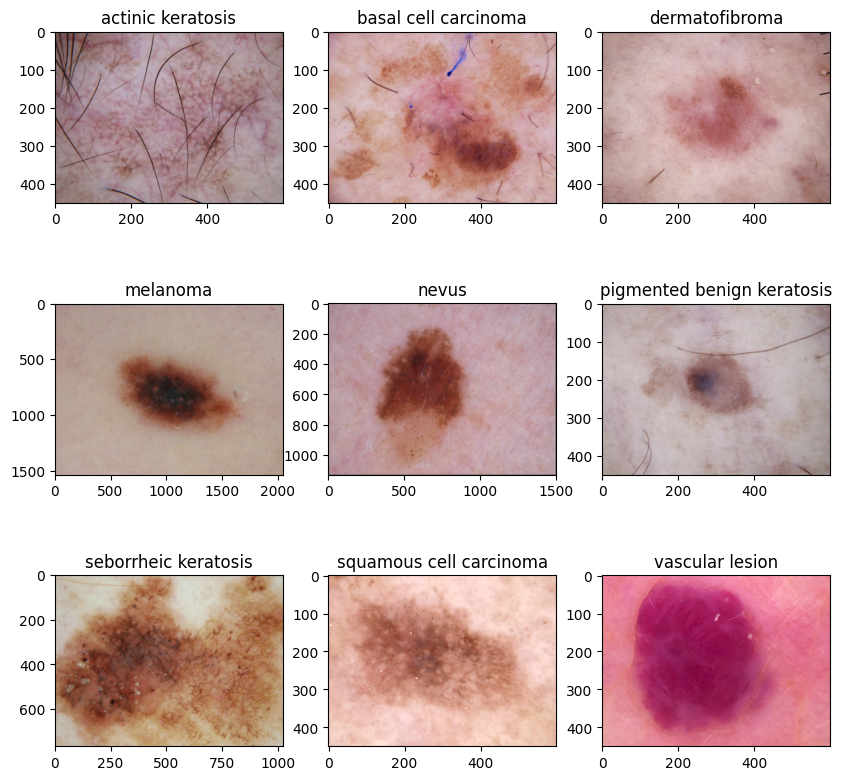

In [32]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset.
 ```Using layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Hence standardizing the values to be in the `[0, 1]` ```


In [35]:
# Model Architecture

input_shape = (img_height, img_width,3)

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_18 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_19 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_20 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_21 (ModuleW  (None, 86, 86, 64)        18496     
 rapper)                                              

### Train the model

In [38]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 139ms/step - loss: 1.9643 - accuracy: 0.2690 - val_loss: 1.7804 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 1.6994 - accuracy: 0.3968 - val_loss: 1.6408 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.6263 - accuracy: 0.4275 - val_loss: 1.6237 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5142 - accuracy: 0.4710 - val_loss: 1.5290 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.4099 - accuracy: 0.5022 - val_loss: 1.4466 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.3123 - accuracy: 0.5424 - val_loss: 1.4691 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 4s 78ms/step - loss: 1.2810 - accuracy: 0.5508 - val_loss: 1.4235 - val_accuracy: 0.5145
Epoch 8/20


### Visualizing training results

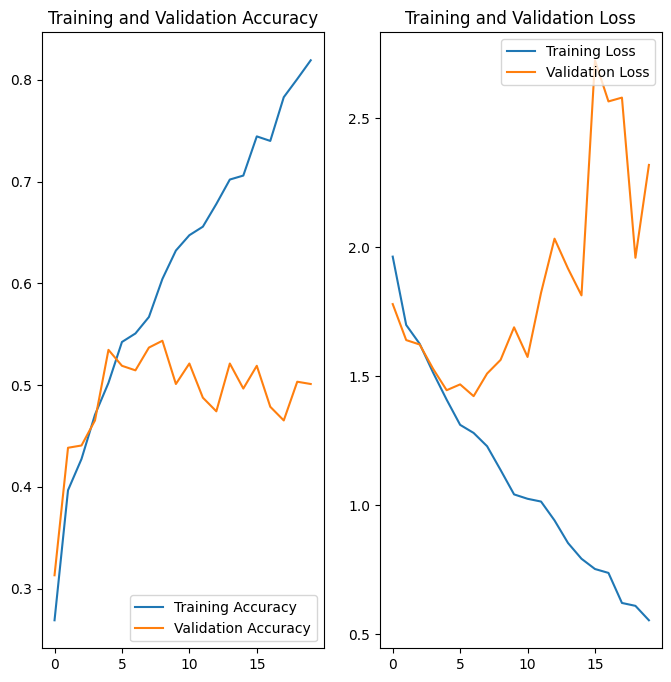

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations on the model outcome

#### Model is overfitting

- The Training accuracy is way higher than the Validation accuracy.
- The Training loss keeps decreasing but Validation loss spikes up, indicating overfitting.

In [40]:
# Defining Basic Data Augmentations to avoid Overfitting

data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

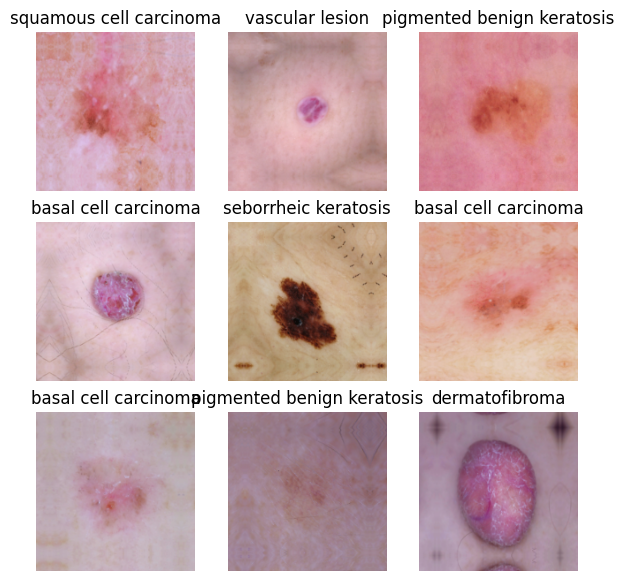

In [41]:
# visualizing  augmentation strategy working for one instance of training image.
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Create the model


In [42]:
## using Additional Dropout layer
# Model Architecture

input_shape = (img_height, img_width,3)

model = Sequential([data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_28 (ModuleW  (None, 178, 178, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_29 (ModuleW  (None, 176, 176, 32)      9248      
 rapper)                                                         
                                                                 
 module_wrapper_30 (ModuleW  (None, 88, 88, 32)        0         
 rapper)                                                         
                                                      

### Training the model

In [44]:
# Model Training

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose =  2
)

## plotting training history
#plot_training_history(history)

Epoch 1/20
56/56 - 6s - loss: 1.9891 - accuracy: 0.2372 - val_loss: 1.9358 - val_accuracy: 0.2461 - 6s/epoch - 110ms/step
Epoch 2/20
56/56 - 4s - loss: 1.8308 - accuracy: 0.3175 - val_loss: 1.8030 - val_accuracy: 0.3423 - 4s/epoch - 74ms/step
Epoch 3/20
56/56 - 4s - loss: 1.6602 - accuracy: 0.3973 - val_loss: 1.5728 - val_accuracy: 0.4698 - 4s/epoch - 72ms/step
Epoch 4/20
56/56 - 4s - loss: 1.5260 - accuracy: 0.4665 - val_loss: 1.5127 - val_accuracy: 0.4720 - 4s/epoch - 72ms/step
Epoch 5/20
56/56 - 4s - loss: 1.6562 - accuracy: 0.4208 - val_loss: 1.5007 - val_accuracy: 0.4944 - 4s/epoch - 71ms/step
Epoch 6/20
56/56 - 4s - loss: 1.4769 - accuracy: 0.4799 - val_loss: 1.5185 - val_accuracy: 0.4787 - 4s/epoch - 71ms/step
Epoch 7/20
56/56 - 4s - loss: 1.4536 - accuracy: 0.4872 - val_loss: 1.4281 - val_accuracy: 0.5213 - 4s/epoch - 70ms/step
Epoch 8/20
56/56 - 4s - loss: 1.4206 - accuracy: 0.4888 - val_loss: 1.5323 - val_accuracy: 0.4698 - 4s/epoch - 74ms/step
Epoch 9/20
56/56 - 4s - loss: 1

### Visualizing the results

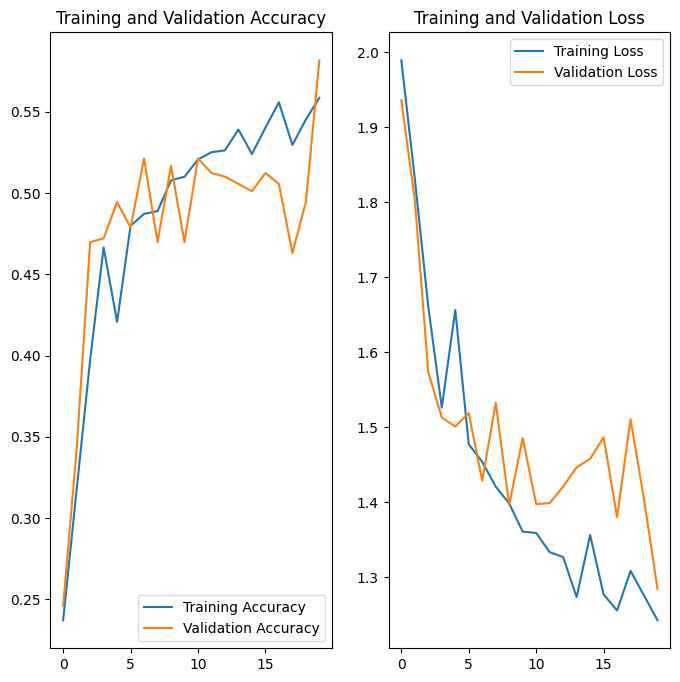

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Observations on the Basic Data Augmentaions Model

- Variance in training and validation data is very minimum, augumentation and dropout has helped reduce overfitting.
- Accuracy of the model has a room for inprovement.

#### The distribution of classes in the training dataset.


,Class,Size,Proportion
5,pigmented benign keratosis,462,51
3,melanoma,438,48
1,basal cell carcinoma,376,41
4,nevus,357,39
7,squamous cell carcinoma,181,20
8,vascular lesion,139,15
0,actinic keratosis,114,12
2,dermatofibroma,95,10
6,seborrheic keratosis,77,8


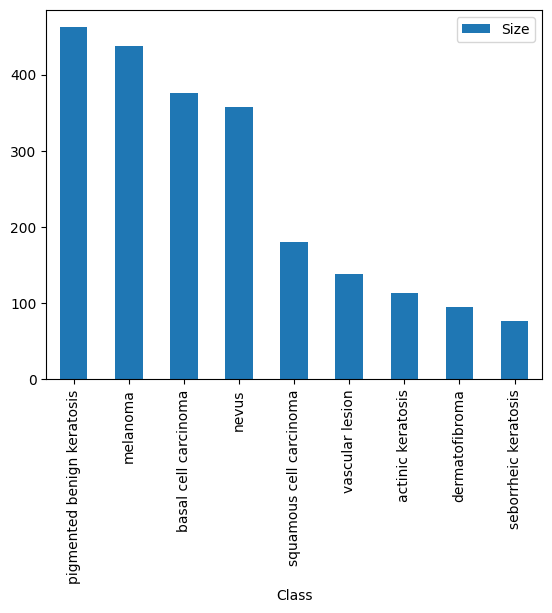

<Figure size 1000x1000 with 0 Axes>

In [46]:
from pathlib import Path

# Create a dictionary to store the class distribution
class_distribution = {}

# Iterate over the subdirectories in the Train directory
for subdir in data_dir_train.iterdir():
    # Get the name of the subdirectory
    subdir_name = subdir.name

    # Check if the subdirectory is a directory
    if subdir.is_dir():
        # Get the number of images in the subdirectory
        num_images = len(list(subdir.iterdir()))

        # Add the number of images to the class distribution dictionary
        class_distribution[subdir_name] = num_images

original_class_distrubution = pd.DataFrame.from_dict(class_distribution,orient='index',columns=['Size'])
original_class_distrubution.index.name = 'Class'
original_class_distrubution = original_class_distrubution.reset_index().sort_values(by='Size',ascending=False)
original_class_distrubution['Proportion'] = original_class_distrubution['Size'] // original_class_distrubution.shape[0]
display(original_class_distrubution)
# create a bar plot
original_class_distrubution.plot(kind='bar', x='Class', y='Size')
plt.figure(figsize=(10,10))
plt.show()


#### Class that has the least number of samples
- *seborrheic keratosis*

#### Classes that dominate the data in terms of proportionate number of samples
- *pigmented benign keratosis*
- *melanoma*
- *basal cell carcinoma*
- *nevus*


#### Using Augumentor to rectify the class imbalance


In [47]:
!pip install Augmentor

In [48]:
path_to_training_dataset="/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x782D70270C10>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x782CEF1B3700>: 100%|██████████| 500/500 [00:23<00:00, 21.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x782CEF486E00>: 100%|██████████| 500/500 [00:22<00:00, 22.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x782CEF49DE10>: 100%|██████████| 500/500 [01:19<00:00,  6.25 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x782D62F03EB0>: 100%|██████████| 500/500 [01:22<00:00,  6.03 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x782D121A8730>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x782CEF3A8130>: 100%|██████████| 500/500 [00:41<00:00, 12.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x782D62F016C0>: 100%|██████████| 500/500 [00:18<00:00, 26.43 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x782CEF49D750>: 100%|██████████| 500/500 [00:25<00:00, 19.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [52]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train) # 500 * 9

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [53]:
# Creating a Path and Label Mapping for Augmented Images

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
display(random.sample(path_list_new,9))

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
random.sample(lesion_list_new,9)

['/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/melanoma/output/melanoma_original_ISIC_0009890.jpg_25a10226-16a1-4e5a-a72e-63909e8fccad.jpg',
 '/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/melanoma/output/melanoma_original_ISIC_0010757.jpg_142f437f-4150-46bb-bde2-2eb13c25af70.jpg',
 '/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_32e2454d-5738-48d3-82d1-e6fecd74a964.jpg',
 '/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_819d16fb-358f-45d8-8624-002f902b403b.jpg',
 '/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030868.jpg_698544b6-7fc1-455b-85f1-b5147d160128.jpg',
 '/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Train/nevus/output/nevus_original_ISIC_0024763.jpg_6a29c462-e4

['melanoma',
 'vascular lesion',
 'melanoma',
 'pigmented benign keratosis',
 'vascular lesion',
 'vascular lesion',
 'basal cell carcinoma',
 'squamous cell carcinoma',
 'melanoma']

### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [56]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

#### Training the model on the data created using Augmentor

#### Creating a training dataset

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating validation dataset

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model with Augumented data

In [63]:
# Using deeper layers as compared to previous model as the Augmented data is large

input_shape = (img_height, img_width,3)

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### Compiling the  model

In [64]:
model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

#### Training the model

In [65]:
from keras.callbacks import ReduceLROnPlateau
epochs = 30
#learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=2,factor=0.2, min_lr=1e-5)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks=[learn_control],
  verbose =  2
)

Epoch 1/30
169/169 - 46s - loss: 1.9134 - accuracy: 0.2749 - val_loss: 1.6851 - val_accuracy: 0.3281 - 46s/epoch - 273ms/step
Epoch 2/30
169/169 - 44s - loss: 1.5840 - accuracy: 0.3930 - val_loss: 1.4294 - val_accuracy: 0.4410 - 44s/epoch - 258ms/step
Epoch 3/30
169/169 - 42s - loss: 1.4429 - accuracy: 0.4531 - val_loss: 1.4054 - val_accuracy: 0.4662 - 42s/epoch - 247ms/step
Epoch 4/30
169/169 - 42s - loss: 1.3238 - accuracy: 0.5030 - val_loss: 1.2876 - val_accuracy: 0.5085 - 42s/epoch - 251ms/step
Epoch 5/30
169/169 - 42s - loss: 1.1781 - accuracy: 0.5608 - val_loss: 1.2748 - val_accuracy: 0.5197 - 42s/epoch - 249ms/step
Epoch 6/30
169/169 - 42s - loss: 1.0728 - accuracy: 0.6026 - val_loss: 1.1563 - val_accuracy: 0.5612 - 42s/epoch - 251ms/step
Epoch 7/30
169/169 - 42s - loss: 0.9536 - accuracy: 0.6400 - val_loss: 1.2879 - val_accuracy: 0.5523 - 42s/epoch - 251ms/step
Epoch 8/30
169/169 - 42s - loss: 0.8544 - accuracy: 0.6931 - val_loss: 1.0168 - val_accuracy: 0.6236 - 42s/epoch - 247

#### Visualize the results of the Augumented model

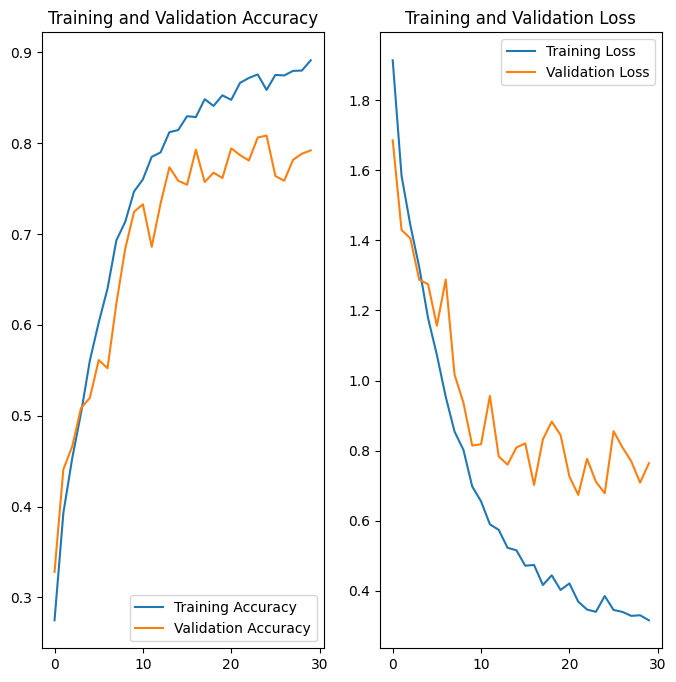

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####Analysing Results of the Augumented Model
- The Augmented model performed better on the validation dataset , compared to previous 2 models.
- The model is more generalised after using the Dropouts and Class balancing
- We have Managed to tackle the overfitting, as train and validation accuracy have greatly improved and we see much lesser spikes during training.
- We were able to achieve a decent accuracy of 79% compared to 50% in the earlier approaches

#### Verifiying the model performance on unseen Test data

1/1 [==============================] - 0s 31ms/step
Actual Class is nevus,Predicted Class nevus


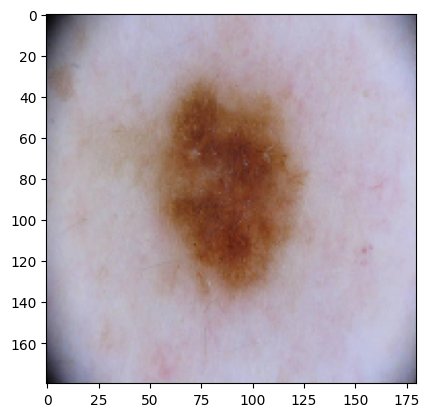

In [69]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Test_image_path = os.path.join(data_dir_test, skin_cancer_class_names[1], '*')
# Test_image = glob(Test_image_path)
Test_image = load_img("/content/drive/My Drive/Data/CNN_assignment/Skin_cancer_ISIC/Test/nevus/ISIC_0000015.jpg",target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred_label = np.argmax(pred)
print(f"Actual Class is nevus,Predicted Class {class_names[pred_label]}")